# 라이브러리

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from lightgbm import LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

# Data Load

In [3]:
df = pd.read_csv("C:/Users/user/Desktop/data/insurance.csv")

# EDA

In [4]:
df.shape

(1338, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


## 빈도수

In [8]:
sample1 = df[["age", "bmi", "charges"]]

def num_desc(data):
    df = data.describe().T
    
    df1 = data.isnull().sum()
    df1.name = "missing"
    
    df2 = data.skew()
    df2.name = "skewness"
    
    df3 = data.kurt()
    df3.name = "kurtosis"

    df4 = data.median()
    df4.name = "median"
    
    df = pd.concat([df, df1, df2, df3, df4], axis=1)
    df["total"] = df["count"] + df["missing"]
    
    order = ["total", "count", "missing", "mean", "median", "std", "skewness", "kurtosis", "min", "max", "25%", "75%"]
        
    num_df = df[order]
    num_df = num_df.round(2)
    
    return num_df

- target 변수를 제외한 연속형 변수들은 크게 치우지지 않은 정규분포와 유사한 형태를 띈다.
- tqrget 변수인 charges는 우측으로 긴 꼬리 형태를 갖는다.

In [9]:
num_desc(sample1)

,total,count,missing,mean,median,std,skewness,kurtosis,min,max,25%,75%
age,1338.0,1338.0,0,39.21,39.00,14.05,0.06,-1.25,18.00,64.00,27.00,51.00
bmi,1338.0,1338.0,0,30.66,30.40,6.10,0.28,-0.05,15.96,53.13,26.30,34.69
charges,1338.0,1338.0,0,13270.42,9382.03,12110.01,1.52,1.61,1121.87,63770.43,4740.29,16639.91


In [10]:
def cat_df(data, col):
    cat_df = data[col].value_counts(dropna=False).to_frame().sort_index(ascending=True).rename(columns={col:"count"}).reset_index()
    cat_df = cat_df.rename(columns={"index":col})

    return cat_df

In [11]:
cat_df(df, "sex")

,sex,count
0,female,662
1,male,676


- 자녀가 없는 경우가 가장 많다.
- 자녀가 4, 5명인 경우의 빈도수는 적다.

In [12]:
cat_df(df, "children")

,children,count
0,0,574
1,1,324
2,2,240
3,3,157
4,4,25
5,5,18


- 흡연 여부의 빈도수는 차이가 크다.

In [13]:
cat_df(df, "smoker")

,smoker,count
0,no,1064
1,yes,274


In [14]:
cat_df(df, "region")

,region,count
0,northeast,324
1,northwest,325
2,southeast,364
3,southwest,325


## 결측치
- 결측치가 존재하지 않는다.

In [15]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## 중복값
- 195, 581 index의 value가 중복되어 있다.
- 하나의 행만을 남기고 제거한다.

In [16]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [17]:
df[(df["age"] == 19) & (df["bmi"] == 30.59) & (df["charges"] == 1639.5631)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [4]:
df = df.drop_duplicates()
df.shape

(1337, 7)

## 이상치
- bmi에 이상치가 존재한다.

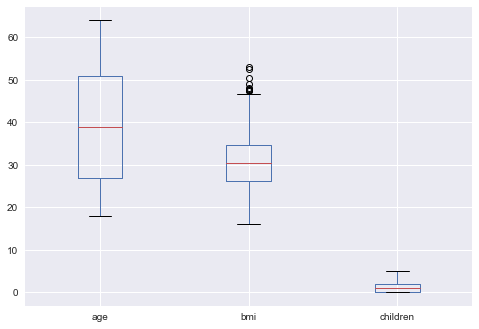

In [19]:
_ = df[["age", "bmi", "children"]].boxplot()

In [20]:
def outlier_df(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    outlier = data[(Q1 - 1.5 * IQR > data[col]) | (data[col] > Q3 + 1.5 * IQR)]
    
    print(f"하한값 : {Q1 - 1.5 * IQR},  상한값 : {Q3 + 1.5 * IQR}")
    return outlier

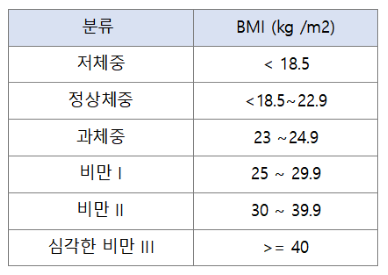

In [21]:
outlier_df(df, "bmi")

하한값 : 13.674999999999994,  상한값 : 47.31500000000001


,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801
847,23,male,50.38,1,no,southeast,2438.05520
860,37,female,47.60,2,yes,southwest,46113.51100
1047,22,male,52.58,1,yes,southeast,44501.39820
1088,52,male,47.74,1,no,southeast,9748.91060
1317,18,male,53.13,0,no,southeast,1163.46270


- 이상치를 상한값으로 대체 후 제대로 대체 되었는지 확인한다.

In [5]:
df.loc[df["bmi"] > 47.31500000000001, "bmi"] = 47.315

In [23]:
outlier_df(df, "bmi")

하한값 : 13.674999999999994,  상한값 : 47.31500000000001


,age,sex,bmi,children,smoker,region,charges


## target 변수(charges)

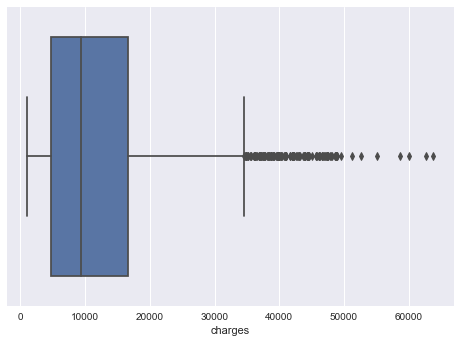

In [24]:
sns.boxplot(data=df, x="charges")
plt.show()

- 위에서 확인했던 것처럼 target 변수는 우측으로 긴 꼬리 형태의 분포를 갖는다.

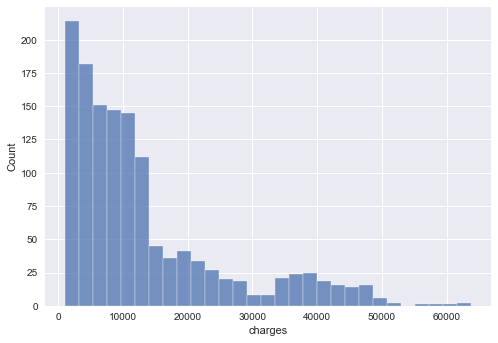

In [25]:
sns.histplot(data=df, x="charges")
plt.show()

- 나이가 많을수록 chrges가 높아진다.

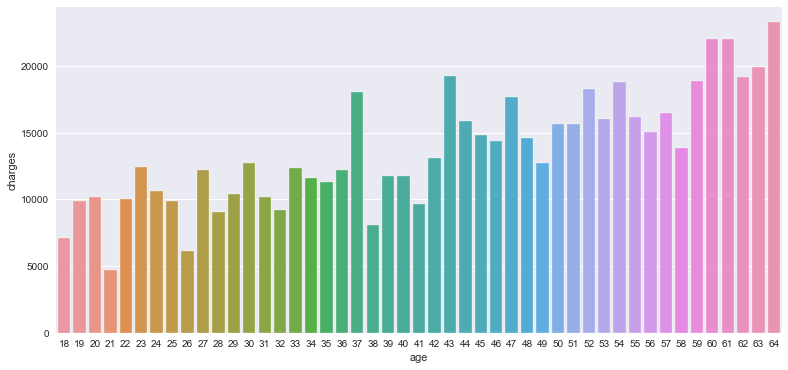

In [26]:
plt.figure(figsize=(13, 6))
sns.barplot(data=df, x="age", y="charges", ci=None)
plt.show()

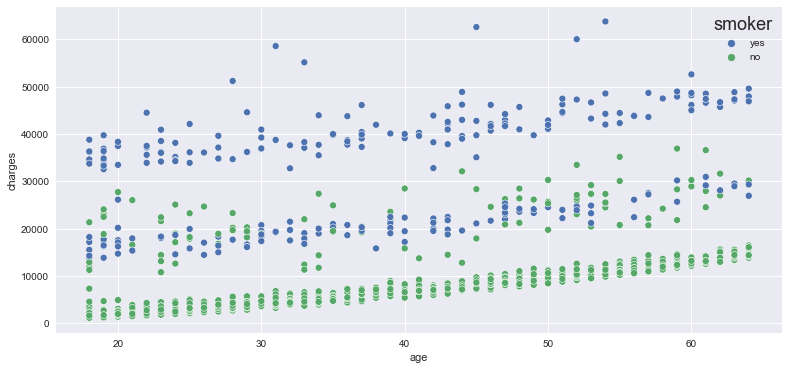

In [27]:
plt.figure(figsize=(13, 6))
sns.scatterplot(data=df, x="age", y="charges", hue="smoker")
plt.show()

- 자녀의 수가 2, 3명일 경우 charges가 높다.
- 자녀의 수가 5명일 경우엔 charges가 낮다.

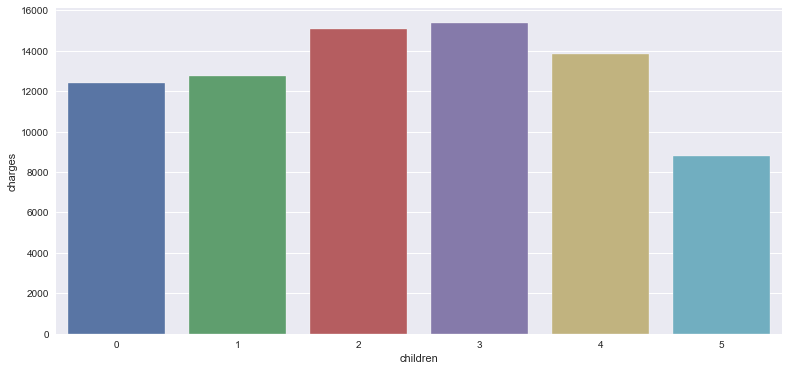

In [28]:
plt.figure(figsize=(13, 6))
sns.barplot(data=df, x="children", y="charges", ci=None)
plt.show()

In [29]:
df.groupby(["children"])[["charges"]].mean().sort_values(by="charges", ascending=False)

,charges
children,
3,15355.318367
2,15073.563734
4,13850.656311
1,12731.171832
0,12384.695344
5,8786.035247


- 남동 지역의 보험료의 평균 수치가 가장 높다.

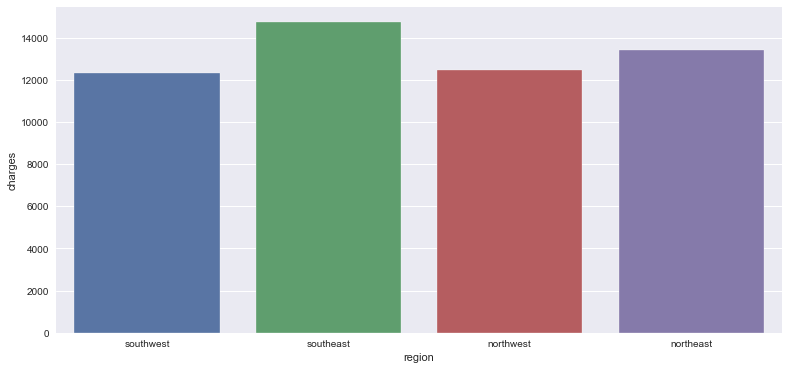

In [30]:
plt.figure(figsize=(13, 6))
sns.barplot(data=df, x="region", y="charges", ci=None)
plt.show()

- 남동 지역의 보험료가 가장 높으며, 대체적으로 동쪽 > 서쪽 순으로 보험료가 높다.

In [31]:
df.groupby(["region"])[["charges"]].mean().sort_values(by="charges", ascending=False)

,charges
region,
southeast,14735.411438
northeast,13406.384516
northwest,12450.840844
southwest,12346.937377


- 흡연자일 경우의 charges가 높다.

In [32]:
df.groupby(["region", "smoker"])[["charges"]].mean().sort_values(by="charges", ascending=False)

charges
region    smoker              
southeast yes     34844.996824
southwest yes     32269.063494
northwest yes     30192.003182
northeast yes     29673.536473
          no       9165.531672
northwest no       8582.467101
southeast no       8032.216309
southwest no       8019.284513

- 흡연자의 경우 bmi가 높아질수록 charges도 높아짐을 확인할 수 있다.
- 흡연자와 비흡연자에 따른 차이가 있어보인다.

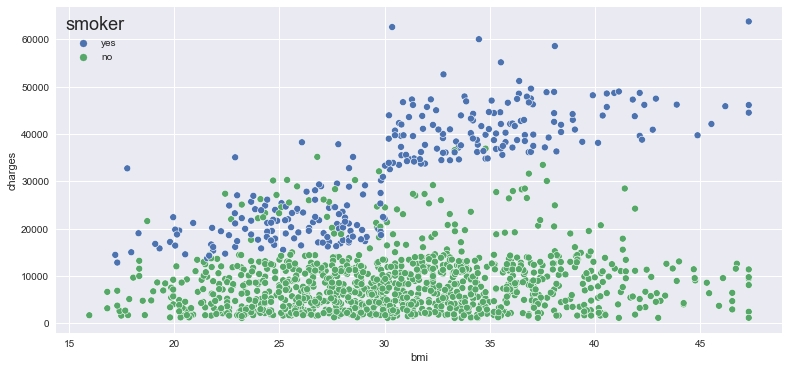

In [33]:
plt.figure(figsize=(13, 6))
sns.scatterplot(data=df, x="bmi", y="charges", hue="smoker")
plt.show()

## 상관관계

In [34]:
df.corr()

,age,bmi,children,charges
age,1.000000,0.111998,0.041536,0.298308
bmi,0.111998,1.000000,0.013692,0.199063
children,0.041536,0.013692,1.000000,0.067389
charges,0.298308,0.199063,0.067389,1.000000


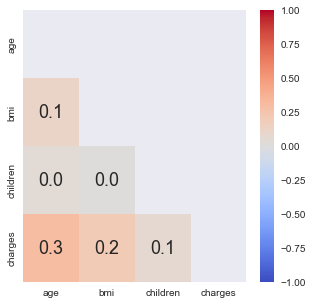

In [35]:
mask = np.triu(np.ones_like(df.corr()))

plt.figure(figsize=(5, 5))
sns.heatmap(df.corr(), cmap="coolwarm", vmin=-1, vmax=1, mask=mask, annot=True, fmt="1.1f")
plt.show()

In [36]:
df[df["age"] >= 43]["charges"].mean()

17116.14130264151

In [37]:
df[df["age"] < 43]["charges"].mean()

10312.301124958878

In [38]:
df[df["age"] >= 43]["charges"].mean() - df[df["age"] < 43]["charges"].mean()

6803.840177682632

# 전처리

## 파생변수

In [6]:
df.loc[df["region"].str.contains("west"), "direction"] = 0
df.loc[df["region"].str.contains("east"), "direction"] = 1

In [7]:
df.loc[df["region"].str.contains("south"), "direction2"] = 0
df.loc[df["region"].str.contains("north"), "direction2"] = 1

In [8]:
df.loc[df["bmi"] < 30, "bmi_high"] = 0
df.loc[df["bmi"] >= 30, "bmi_high"] = 1

In [9]:
df.loc[df["age"] < 43, "age_high"] = 0
df.loc[df["age"] >= 43, "age_high"] = 1

In [10]:
df.loc[(df["children"] == 4) | (df["children"] == 5), "children"] = 4

## 스케일링

- target 변수 로그 변환

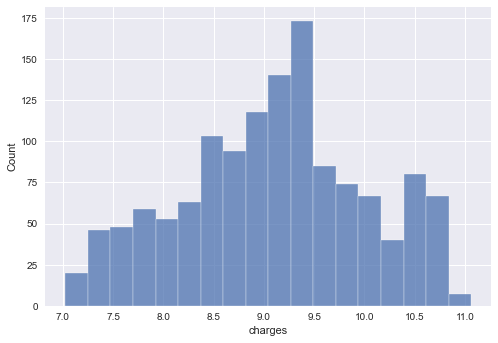

In [51]:
# df["charges"] = np.log1p(df["charges"])

# sns.histplot(data=df, x="charges")
# plt.show()

- 범주형 변수 LabelEncoding

In [11]:
label_cols = ["sex", "region", "smoker"]

scale = LabelEncoder()
df[label_cols] = df.loc[:, label_cols].apply(scale.fit_transform)

- 연속형 변수 MinMaxScaling

In [12]:
scale = MinMaxScaler()
df[["age", "bmi"]] = scale.fit_transform(df[["age", "bmi"]])

In [13]:
df[["direction", "direction2", "bmi_high", "age_high"]] = df[["direction", "direction2", "bmi_high", "age_high"]].astype(int)

In [14]:
df.head()

,age,sex,bmi,children,smoker,region,charges,direction,direction2,bmi_high,age_high
0,0.021739,0,0.380801,0,1,3,16884.92400,0,0,0,0
1,0.000000,1,0.568011,1,0,2,1725.55230,1,0,1,0
2,0.217391,1,0.543454,3,0,2,4449.46200,1,0,1,0
3,0.326087,1,0.215117,0,0,1,21984.47061,0,1,0,0
4,0.304348,1,0.412055,0,0,1,3866.85520,0,1,0,0


# 모델링

In [15]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [16]:
X = df.drop(["charges"], axis=1)
y = df["charges"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1069, 10), (1069,), (268, 10), (268,))

In [295]:
learning_rate= [0.05, 0.1, 0.2, 0.3]
max_depth = [3, 4, 5, 6]
n_estimators = [100, 150, 200, 250, 300]

param_grid = dict(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)

gs = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
result = gs.fit(X_train, y_train)

print(f"Best Score : {result.best_score_}")
print(f"Best Params : {result.best_params_}")
print(gs.best_estimator_)

Best Score : 0.8429036748186027
Best Params : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
GradientBoostingRegressor(learning_rate=0.05, random_state=42)


In [18]:
model = GradientBoostingRegressor(learning_rate=0.05, random_state=42)

bagging = BaggingRegressor(model, max_samples=0.55, n_estimators=5, random_state=42)
bagging.fit(X_train, y_train)
predict = bagging.predict(X_test)

In [19]:
print(f"Bagging Train Score : {round(bagging.score(X_train, y_train), 3)}")
print(f"Bagging Test Score : {round(bagging.score(X_test, y_test), 3)}")

Bagging Train Score : 0.871
Bagging Test Score : 0.905


In [22]:
print(f"NMAE : {round(NMAE(y_test, predict), 3)}")
print(f"MAE : {round(mean_absolute_error(y_test, predict))}")
print(f"MSE : {round(mean_squared_error(y_test, predict))}")
print(f"RMSE : {round(np.sqrt(mean_squared_error(y_test, predict)))}")
print(f"RMSLE : {round((mean_squared_log_error(y_test, predict)) ** 0.5, 2)}")
print(f"R Square : {round(r2_score(y_test, predict), 3)}")

NMAE : 0.166
MAE : 2365
MSE : 17546221
RMSE : 4189
RMSLE : 0.39
R Square : 0.905


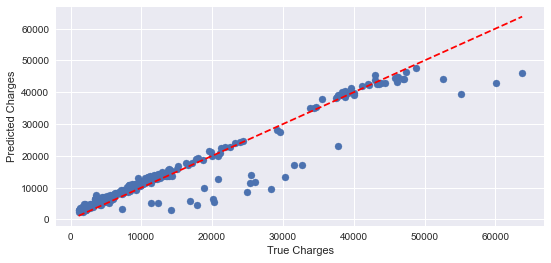

In [132]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test, predict)
plt.plot([1121.87, 63770.43], [1121.87, 63770.43], '--r')
plt.xlabel("True Charges")
plt.ylabel("Predicted Charges")
plt.tight_layout()

- 최종 모델 성능

In [ ]:
NMAE : 0.166
MAE : 2365
MSE : 17546221
RMSE : 4189
RMSLE : 0.39
R Square : 0.905